In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.spatial.distance import pdist, squareform
from sklearn.utils import shuffle

In [2]:
from mnist import MNIST
mndata = MNIST('./data/mnist/')
train, train_labels = map(np.array, mndata.load_training())
test, test_labels = map(np.array, mndata.load_testing())
train = train /255
test = test / 255
N = train.shape[1]

We want to generate 2D GP random features which resemble gabor filters for image classification. We will define the covariance function of the GP as follow. Given pixel locations $x, y \in \mathbb{R}^{2}$ and center of the receptive field $m$, our covariance function will be a gaussian modulating another gaussian.


### $k(x, y, m) = c \cdot e^{-\dfrac{\|x-y\|^2}{2l^2}} \cdot e^{-\dfrac{\|x-m\|^2}{2t^2}} \cdot e^{-\dfrac{\|y-m\|^2}{2t^2}} $

In [3]:
def gabor_kernel_matrix(N, t, l, m):
    x = np.arange(np.sqrt(N))
    yy, xx = np.meshgrid(x, x)
    grid = np.column_stack((xx.flatten(), yy.flatten()))
    
    a = squareform(pdist(grid, 'sqeuclidean'))
    b = la.norm(grid - m, axis=1) ** 2
    c = b.reshape(-1, 1)
    K = 10 * np.exp(-a / (2 * l ** 2)) * np.exp(-b / (2 * t ** 2)) * np.exp(-c / (2 * t ** 2))
    K += 1e-5 * np.eye(N)
    return K

def gabor_random_features_for_center(M, N, t, l, m):
    K = gabor_kernel_matrix(N, t, l, m)
    L = np.linalg.cholesky(K)
    w = np.dot(L, np.random.randn(N, M))
    return w

def gabor_random_features(M, N, t, l, n_centers=80):
    centers = np.random.randint(int(np.sqrt(N)), size=(n_centers, 2))

    W = np.empty(shape=(0, N))
    for m in centers:
        w = gabor_random_features_for_center(M, N, t, l, m)
        W = np.row_stack((W, w.T))
    return W

#### visualize the random features given t and l

In [4]:
m = [5, 5] # center of the 
t = 5.84 # scale of bump
l = 3.25 # scale of wiggles
M = 20

K = gabor_kernel_matrix(N, t, l, m)
W = gabor_random_features(M, N, t, l, n_centers=40)

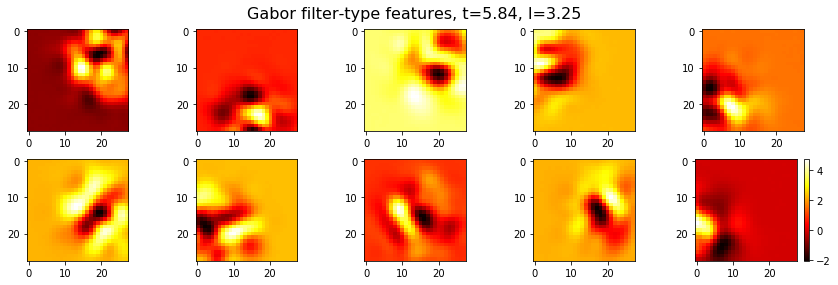

In [22]:
rand_W = W[np.random.randint(0, len(W), 20)]
n = int(np.sqrt(N))
fig = plt.figure(figsize=(12,4))
plt.suptitle('Gabor filter-type features, t=%0.2f, l=%0.2f' % (t, l), fontsize=16)
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    plt.imshow(rand_W[i].reshape(n, n), cmap='hot')
plt.colorbar()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('figures/MNIST/random_features.png')

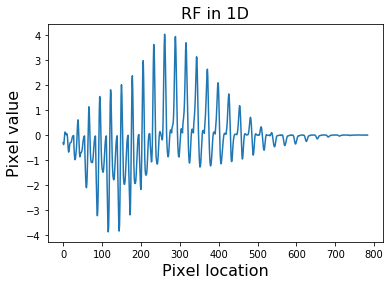

In [77]:
fig = plt.figure(figsize=(6, 4))
plt.title('RF in 1D', fontsize=16)
plt.plot(W[121])
plt.xlabel('Pixel location', fontsize=16)
plt.ylabel('Pixel value', fontsize=16)
plt.savefig('figures/MNIST/random_feature_1d.png')

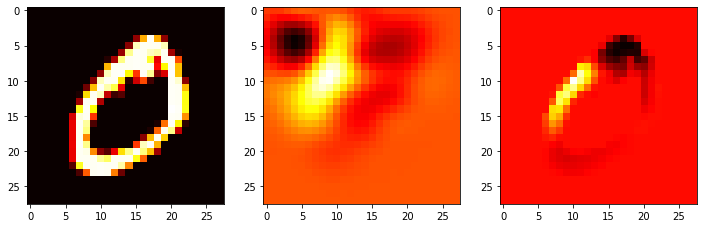

In [30]:
i = np.random.randint(len(W))
x = train[1]
y = x * W[i]
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(131)
plt.imshow(x.reshape(28, 28), cmap='hot')

ax = fig.add_subplot(132)
plt.imshow(W[i].reshape(28, 28), cmap='hot')
# plt.colorbar()

ax = fig.add_subplot(133)
plt.imshow(y.reshape(28, 28), cmap='hot')
# plt.colorbar()
plt.savefig('figures/MNIST/MNIST_digit.png')

## Classify

In [37]:
from estimator import RFClassifier, relu
from sklearn.utils import shuffle
import dask

In [38]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

#### Let's find the best params for `t` and `l` by cross validation.

In [9]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [10]:
# separate data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train, train_labels, train_size=3000, random_state=42)

In [23]:
n_features = 20
n_centers = 20
params = np.random.uniform(0, 6, size=(50, 2))

# weight function
f_gabor = lambda M, N: gabor_random_features(M, N, t, l, n_centers=n_centers).T
weights = [('gabor', f_gabor), ('white noise', None)]

# non-linearities
h = {'relu': relu, 'x^2': lambda x: x **2, 'x^3': lambda x: x ** 3}
non_lin = 'relu'

In [24]:
results = []
for t, l in tqdm(params):
    f = lambda M, N:gabor_random_features(M, N, t, l, n_centers=n_centers).T
    clf = RFClassifier(width=n_features, weights='gabor', weight_fun= f, nonlinearity=h[non_lin])
    clf.fit(X_train, y_train)
    val_err = 1 - clf.score(X_val, y_val)
    train_err = 1 - clf.score(X_train, y_train)
#     print('t=%0.2f, l=%0.2f, train_err=%0.2f, val_err=%0.2f' % (t, l, train_err, val_err))
    results.append([t, l, train_err, val_err])

  0%|          | 0/50 [00:00<?, ?it/s]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
  2%|▏         | 1/50 [00:07<05:50,  7.16s/it]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
  4%|▍         | 2/50 [00:14<05:44,  7.18s/it]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
  6%|▌         | 3/50 [00:17<04:34,  5.84s/it]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterat

 64%|██████▍   | 32/50 [02:05<01:01,  3.41s/it]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 66%|██████▌   | 33/50 [02:08<00:58,  3.41s/it]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 68%|██████▊   | 34/50 [02:10<00:49,  3.09s/it]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 70%|███████   | 35/50 [02:14<00:50,  3.35s/it]/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

In [87]:
# find the params that gives the best classification
results = np.array(results)
print(results[np.argmin(results[:, 3])])
t_cv, l_cv = results[np.argmin(results[:, 3])][:2]
# print(results[results[:, 3] < 0.08])

IndexError: too many indices for array

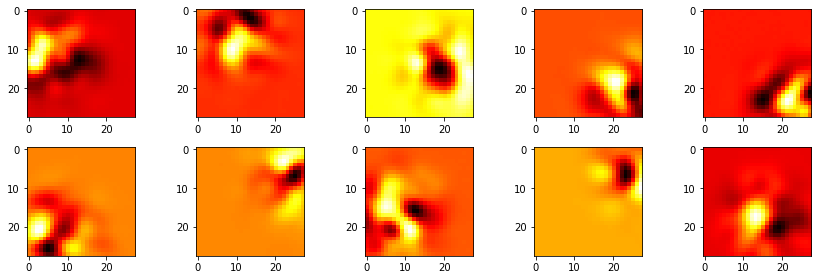

In [27]:
# visualize features from params above
W = gabor_random_features(n_features, train.shape[1], t_cv, l_cv, n_centers=n_centers)
n = int(np.sqrt(N))
fig = plt.figure(figsize=(12, 4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    idx = np.random.randint(len(W))
    plt.imshow(W[idx].reshape(n, n), cmap='hot')
# plt.colorbar()
plt.tight_layout()

In [86]:
# # clf using the same number of white noise features
# for i in range(5):
#     clf = RFClassifier(width=n_features * n_centers, weights='white noise', nonlinearity=h[non_lin])
#     clf.fit(X_train, y_train)
#     val_err = 1 - clf.score(X_val, y_val)
#     train_err = 1 - clf.score(X_train, y_train)
#     print('train_err=%0.2f, val_err=%0.2f' % (train_err, val_err))

#### Using params above, let's classify all of the data points.

In [121]:
X_train, y_train = train.copy(), train_labels.copy()
X_test, y_test = test.copy(), test_labels.copy()

In [122]:
n_features = np.arange(1, 50, 5)
n_centers = 20

t = t_cv.copy() # scale of bump
l = l_cv.copy() # scale of wiggles

# weight function
f_gabor = lambda M, N: gabor_random_features(M, N, t, l, n_centers=n_centers).T
weights = [('gabor', f_gabor), ('white noise', None)]

# non-linearities
h = {'relu': relu, 'x^2': lambda x: x **2, 'x^3': lambda x: x ** 3}
non_lin = 'relu'

In [123]:
%%time 
results = {wt:[] for (wt, func) in weights}
for (wt, func) in weights:
    for n in n_features:
        if wt == 'white noise':
            n = n * n_centers
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h[non_lin]}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(1)]
        results[wt].append(np.real(dask.compute(*lazy_results)))
        print(wt, n)

gabor 1
gabor 6
gabor 11
gabor 16
gabor 21
gabor 26
gabor 31
gabor 36
gabor 41
gabor 46
white noise 20
white noise 120
white noise 220
white noise 320
white noise 420
white noise 520
white noise 620
white noise 720
white noise 820
white noise 920
CPU times: user 12min 11s, sys: 3min 7s, total: 15min 18s
Wall time: 57min 13s


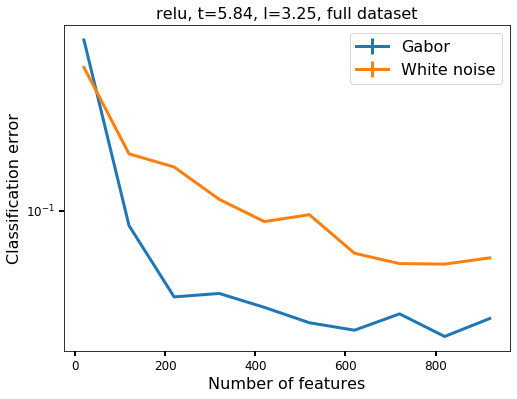

In [135]:
# compute mean
mean_err_gabor, std_err_gabor = np.mean(results['gabor'], axis=1), np.std(results['gabor'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

# plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.title('%s, t=%0.2f, l=%0.2f, full dataset' % (non_lin, t_cv, l_cv), fontsize=16)
ax.errorbar(n_features * n_centers, mean_err_gabor, yerr=std_err_gabor, fmt='-', label='Gabor',  markersize=4, lw=3)
ax.errorbar(n_features * n_centers, mean_err_wn, yerr=std_err_wn, fmt='-', label='White noise',  
            markersize=4, lw=3)
ax.set_yscale('log')
# plt.xlim([0, 200])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)

# plt.savefig('figures/MNIST/clf_full_dataset_%s.png' % non_lin)

#### Let's use a subset of the dataset to see if our random features work better than random features.

In [39]:
from sklearn.model_selection import train_test_split

num_train = 50
X_train, _, y_train, _ = train_test_split(train, train_labels, train_size=num_train, random_state=42)
X_test, y_test = test.copy(), test_labels.copy()

In [40]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43067 Dashboard: http://127.0.0.1:38759/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [33]:
print('num egs per digit: ', [len(y_train[y_train == i]) for i in range(10)])

num egs per digit:  [4, 7, 4, 6, 6, 1, 8, 5, 6, 3]


In [41]:
n_features = np.arange(1, 50, 5)
n_centers = 20

# t = t_cv.copy() # scale of bump
# l = l_cv.copy() # scale of wiggles

# weight function
f_gabor = lambda M, N: gabor_random_features(M, N, t, l, n_centers=n_centers).T
weights = [('gabor', f_gabor), ('white noise', None)]

# non-linearities
h = {'relu': relu, 'x^2': lambda x: x **2, 'x^3': lambda x: x ** 3}
non_lin = 'relu'

print(n_features * n_centers)

[ 20 120 220 320 420 520 620 720 820 920]


In [111]:
results = {wt:[] for (wt, func) in weights}
for (wt, func) in weights:
    for n in n_features:
        if wt == 'white noise':
            n = n * n_centers
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h[non_lin]}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))
        print(wt, n)

gabor 1
gabor 6
gabor 11
gabor 16
gabor 21
gabor 26
gabor 31
gabor 36
gabor 41
gabor 46
gabor 51
gabor 56
gabor 61
gabor 66
gabor 71
gabor 76
gabor 81
gabor 86
gabor 91
gabor 96
white noise 20
white noise 120
white noise 220
white noise 320
white noise 420
white noise 520
white noise 620
white noise 720
white noise 820
white noise 920
white noise 1020
white noise 1120
white noise 1220
white noise 1320
white noise 1420
white noise 1520
white noise 1620
white noise 1720
white noise 1820
white noise 1920


/home/bpandey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


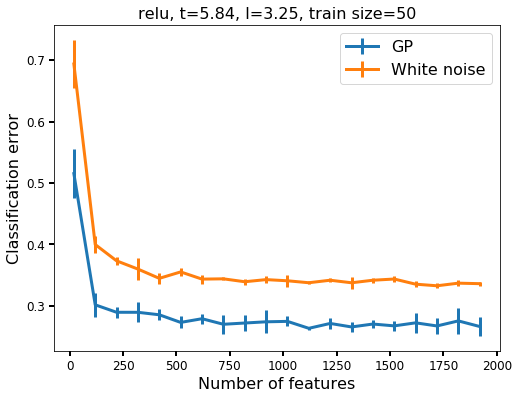

In [115]:
# compute mean
mean_err_gabor, std_err_gabor = np.mean(results['gabor'], axis=1), np.std(results['gabor'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

# plot
fig = plt.figure(figsize=(8, 6))
plt.title('%s, t=%0.2f, l=%0.2f, train size=%d' % (non_lin, t_cv, l_cv, num_train), fontsize=16)
ax = fig.add_subplot(111)
ax.errorbar(n_features * n_centers, mean_err_gabor, yerr=std_err_gabor, fmt='-', label='GP',  markersize=4, lw=3)
ax.errorbar(n_features * n_centers, mean_err_wn, yerr=std_err_wn, fmt='-', label='White noise',  
            markersize=4, lw=3)
# ax.set_yscale('log')
# plt.xlim([0, 200])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)
plt.savefig('figures/MNIST/clf_subsample_dataset_%s_%dpts.png' % (non_lin, num_train))

In [44]:
clf = RFClassifier(width=20, weights='gabor', weight_fun= f_gabor, nonlinearity= h[non_lin])

In [47]:
clf.fit(X_train, y_train)

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RFClassifier(clf=LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=294,
                           tol=0.0001, verbose=0),
             clf_args={}, nonlinearity=<function relu at 0x7f3a842c0b90>,
             seed=294, weight_fun=<function <lambda> at 0x7f3abc442170>,
             weights='gabor', width=20)

In [58]:
clf_wts = clf.clf.coef_

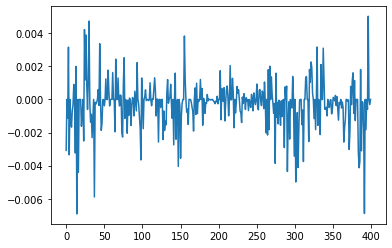

In [65]:
fig = plt.figure()
plt.plot(clf_wts[9])